<a href="https://colab.research.google.com/github/shayar/DM-Final-Project/blob/main/MJC_SS_Data_Mining_Final_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Data Mining Final Project

by

Matthew Curran and

Shayar Shrestha

# Load Data and Imports

In [87]:
!pip install umap-learn

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

url = 'http://pluto.hood.edu/~dong/datasets/osa_hf.csv'
data = pd.read_csv(url, header='infer')
data.head(1)

,bmi,hospital_expire_flag,los,age,charlson,"Calculated Bicarbonate, Whole Blood",Calculated Total CO2,"Chloride, Whole Blood",Free Calcium,Glucose,...,insurance_Medicare,insurance_Other,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT
0,0.21743,0,0.902069,0.611765,0.45,0.0,0.068493,0.090909,0.564516,0.103448,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# EDA

Dataset Overview
Shape: (10841, 764)
Column Data Types:
float64    763
int64        1
Name: count, dtype: int64
No missing values found.

Unique Values in Each Column:
Hepatitis A Virus IgM Antibody                             1
Lymphocytes.2                                              1
Salicylate                                                 1
Benzodiazepine Screen                                      1
Rheumatic disorders of both mitral and aortic valves       2
                                                        ... 
Creatinine                                                49
Glucose.1                                                 52
age                                                       82
bmi                                                      856
los                                                     7502
Length: 764, dtype: int64

Constant Features (No Variance): ['Benzodiazepine Screen', 'Hepatitis A Virus IgM Antibody', 'Salicylate', 'Lymphocytes.2']

Summary S

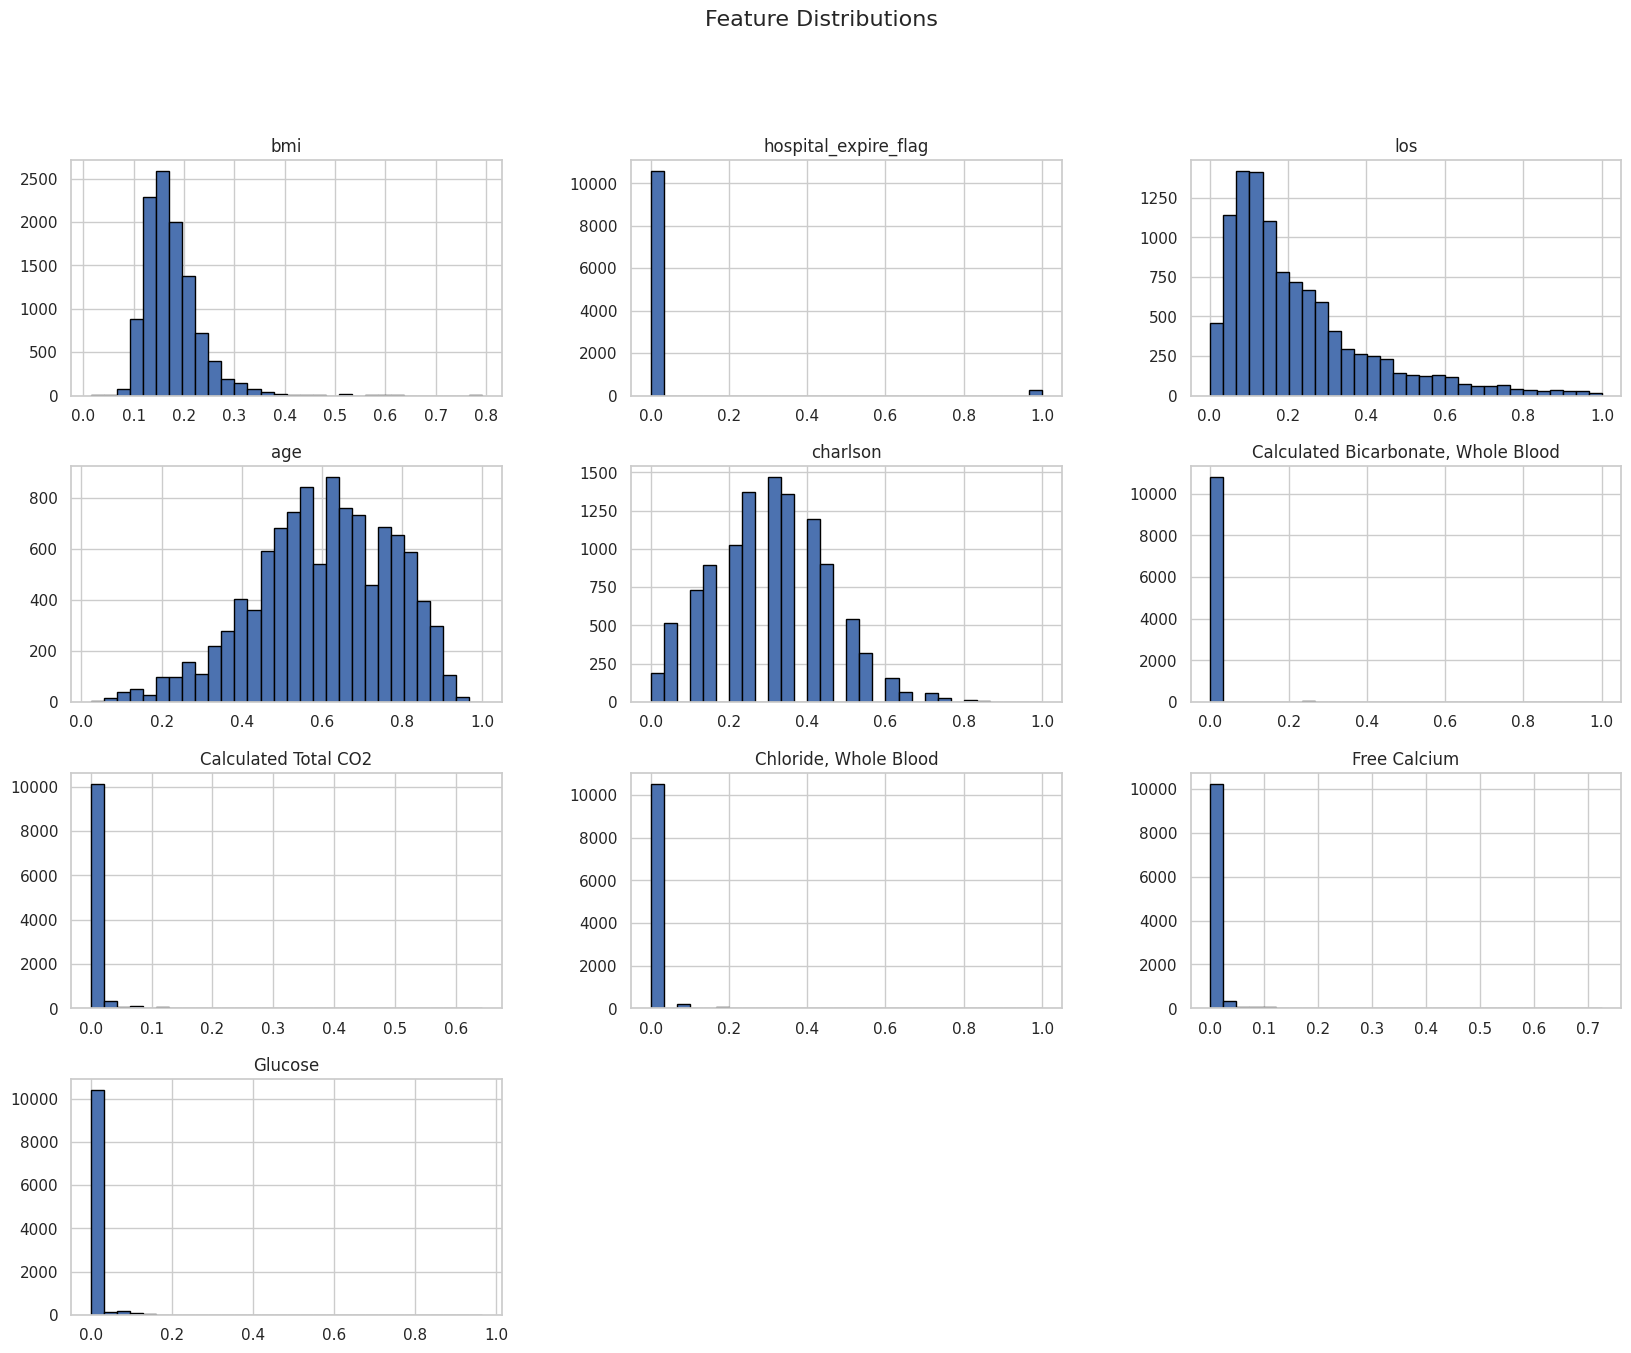


Correlation Matrix:


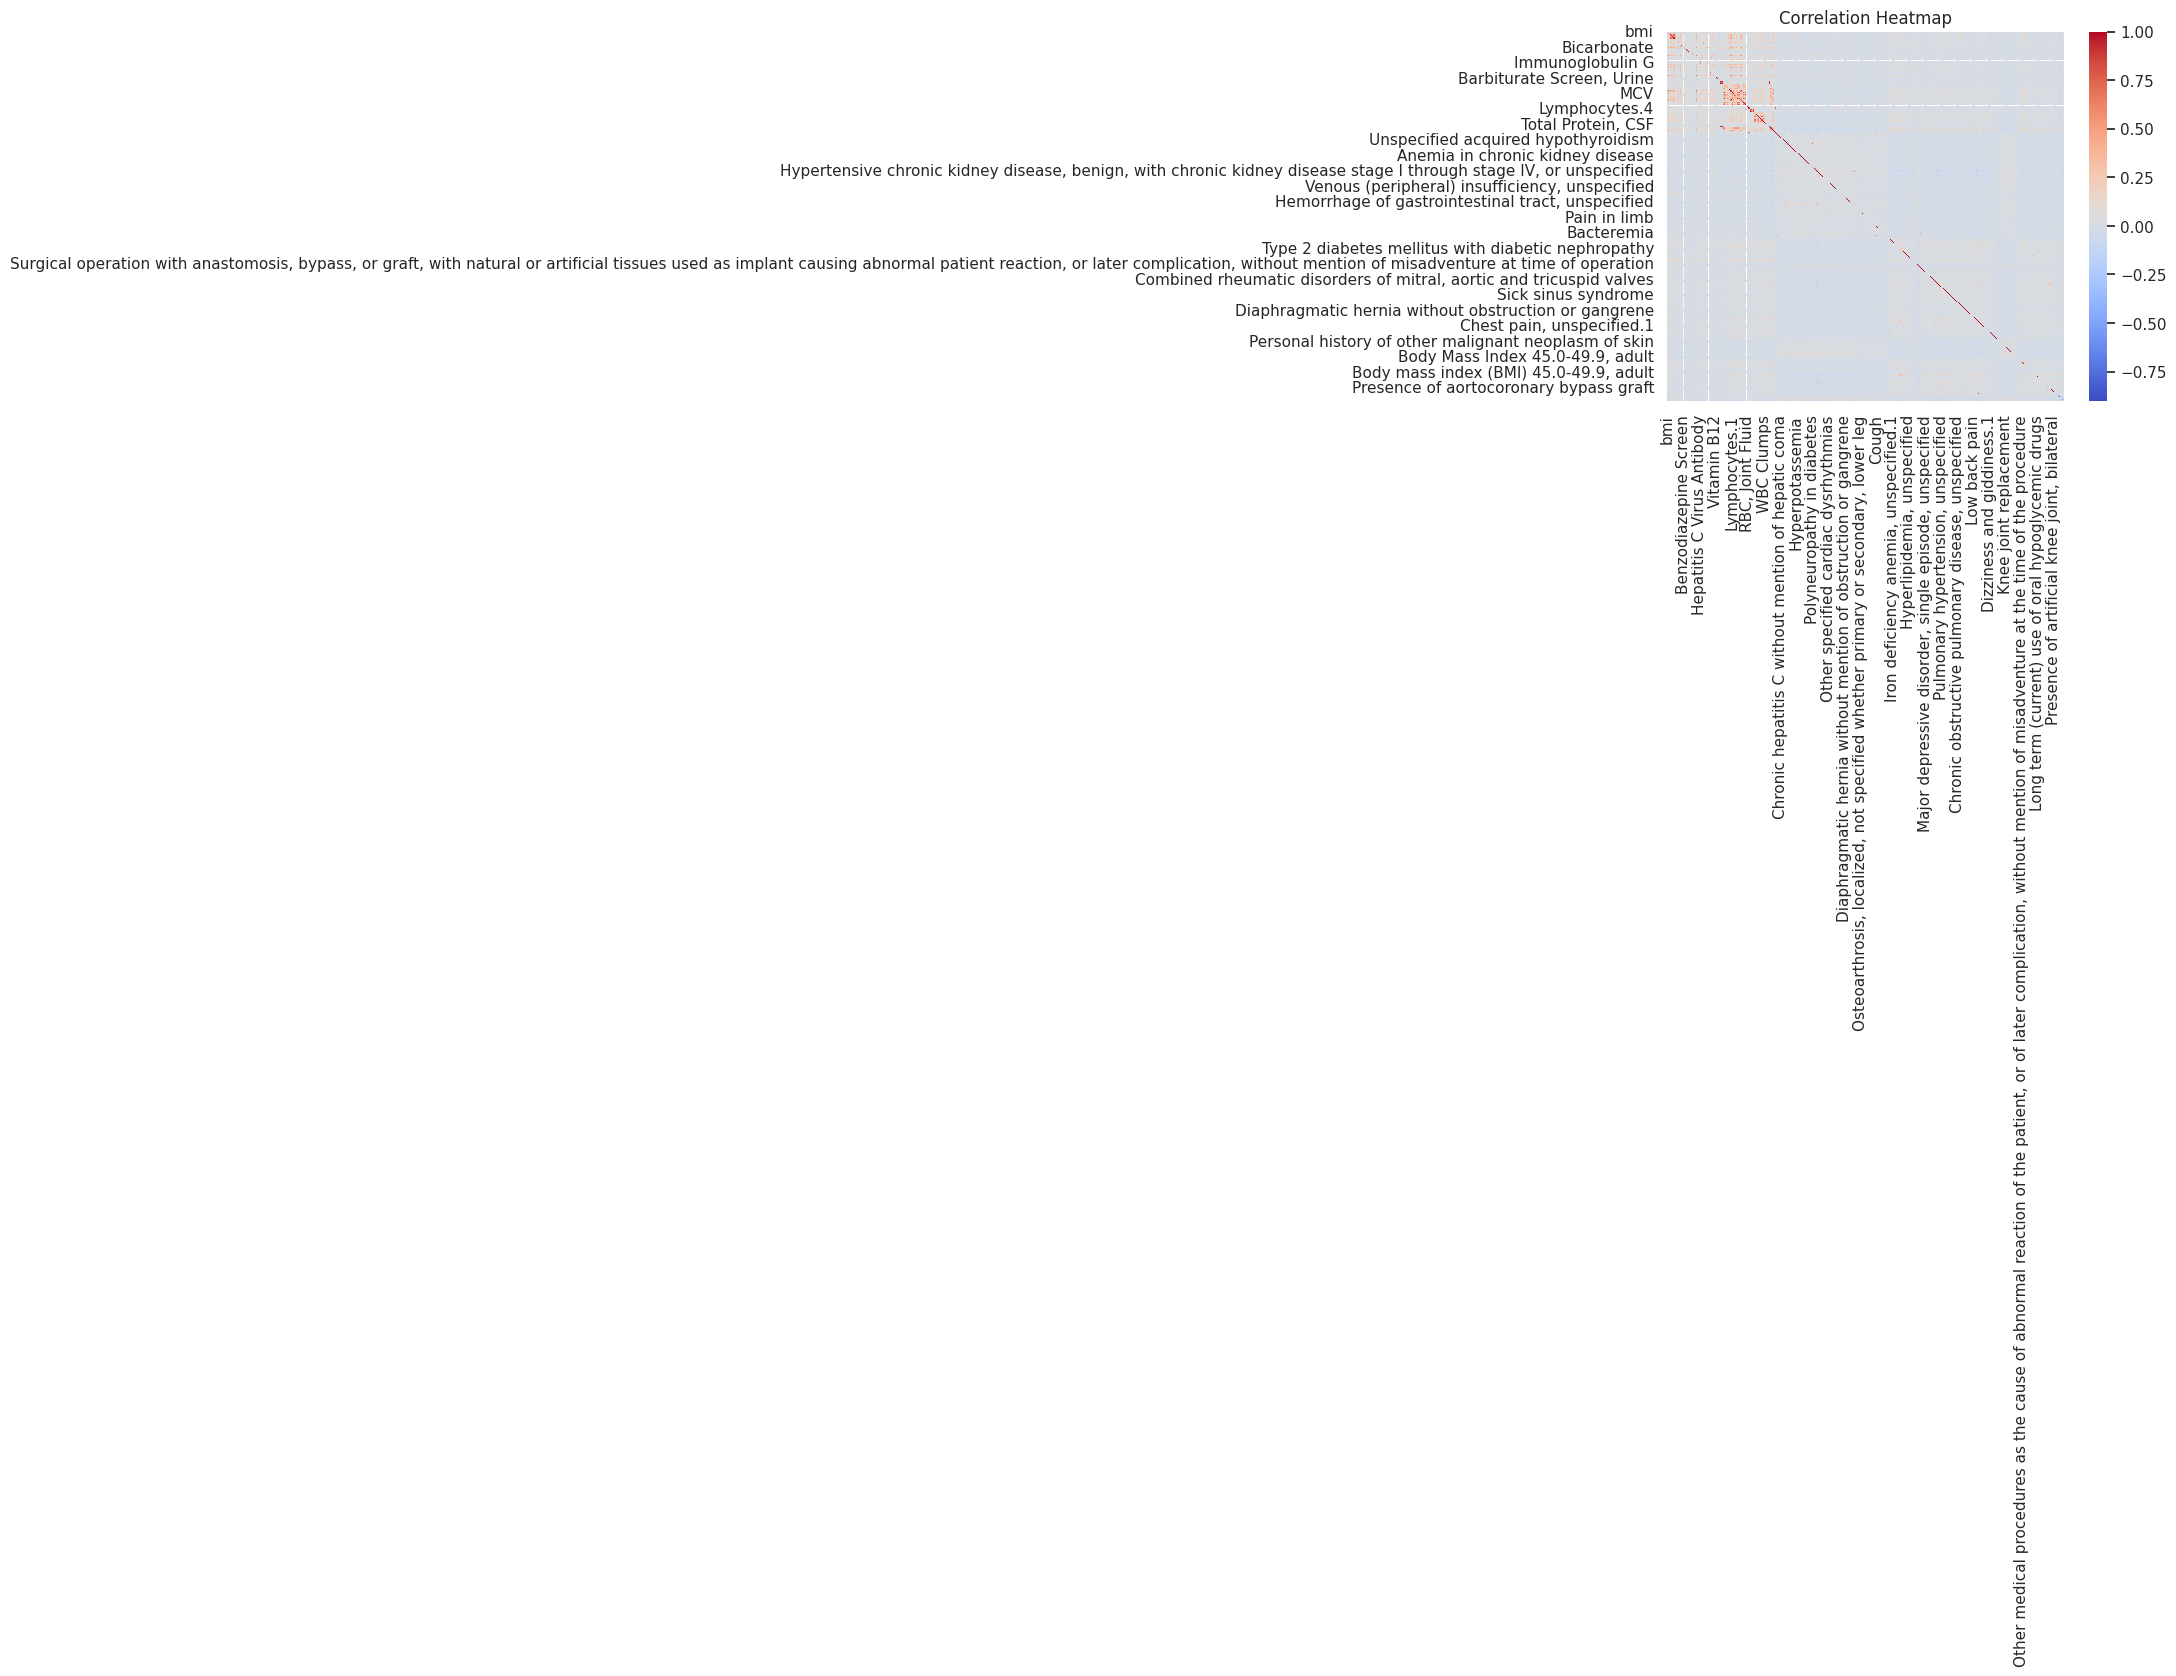


Highly Correlated Feature Pairs (Correlation > 0.85):
INR(PT)                                                                                                           PT                                 0.998946
Iron Binding Capacity, Total                                                                                      Transferrin                        0.995909
Lymphocytes                                                                                                       Total Nucleated Cells, Ascites     0.993811
RBC, Ascites                                                                                                      Total Nucleated Cells, Ascites     0.990722
Lymphocytes.4                                                                                                     Total Nucleated Cells, Pleural     0.988424
Polys                                                                                                             Total Nucleated Cells, Ascites     0.9876

In [89]:
print("Dataset Overview")
print(f"Shape: {data.shape}")
print("Column Data Types:")
print(data.dtypes.value_counts())

# Check for missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing Values Count:")
    print(missing_values)
else:
    print("No missing values found.")

# Checking unique values
print("\nUnique Values in Each Column:")
print(data.nunique().sort_values())

# Identifying features with only one unique value, as they provide no useful information
constant_features = [col for col in data.columns if data[col].nunique() == 1]
print("\nConstant Features (No Variance):", constant_features)

# Summary statistics
print("\nSummary Statistics:")
print(data.describe().T)

# Visualize the distribution of a random sample of columns (for the first 10 columns)
print("\nVisualizing feature distributions...")
data.iloc[:, :10].hist(figsize=(20, 15), bins=30, layout=(4, 3), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

# Correlational Analysis
print("\nCorrelation Matrix:")
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Checking highly correlated features (correlations above 0.85)
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr_pairs.stack().sort_values(ascending=False)
print("\nHighly Correlated Feature Pairs (Correlation > 0.85):")
print(high_corr_pairs[high_corr_pairs > 0.85])

# Outlier Detection
outlier_counts = {}
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        outlier_counts[col] = outliers
print("\nOutliers Detected:")
print(outlier_counts)

# EDA Conclusion:

*  There were no any missing values found in any column along with the features having valid data.
*    While checking the uniqueness of the features, these 4  feature i.e (Benzodiazepine Screen', 'Hepatitis A Virus IgM Antibody', 'Salicylate', 'Lymphocytes.2) didn't have any variance.
* Checking the correlation between the features, we got to see that only few of them were highly correlated while most of the features didn't have good correlations.
* From the summary statistics, we didn't learn anything.
* From the feature visualization, we can see that most of the feature are normal distribution. Given, the large amount of feature, it is impossible to look for each feature. We didn't see anything unusual.
* While detecting the outliers, we found alot of the features had outliers. Since, we lack SME (subject matter expertise) in this topic, we couldn't determine which outlier might represent bad data.
* We checked all the columns manually, if they contain ID in them, but there were some but they were not real IDs.

Final Conclusion from EDA:

* Although, there are alot of features and its a large dataset, we can see that all of them have good data.

# Data Preprocessing

In [90]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# K-Means Helper Function

In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def kMeansHelper(data):
  # Determine optimal number of clusters using the elbow method
  inertia = []
  sil_scores = []
  davies_bouldin_scores = []
  range_clusters = range(2, 10)

  for k in range_clusters:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(data)
      inertia.append(kmeans.inertia_)
      sil_scores.append(silhouette_score(data, kmeans.labels_))
      davies_bouldin_scores.append(davies_bouldin_score(data, kmeans.labels_))

  # Elbow method plot
  plt.figure(figsize=(8, 5))
  plt.plot(range_clusters, inertia, marker='o')
  plt.title(f'Elbow Method for Optimal K with dimension = {data.shape[1]}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

  # Silhouette scores plot
  plt.figure(figsize=(8, 5))
  plt.plot(range_clusters, sil_scores, marker='o', color='orange')
  plt.title(f'Silhouette Scores for Different K with dimension = {data.shape[1]}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.show()

  print(f"Silhouette Scores: {sil_scores}")
  print(f"Davies-Bouldin Scores: {davies_bouldin_scores}\n")

# K-Means before Dimension Reduction

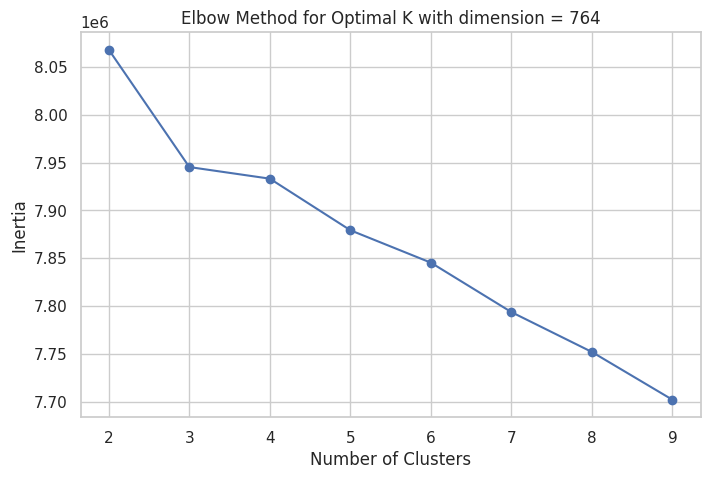

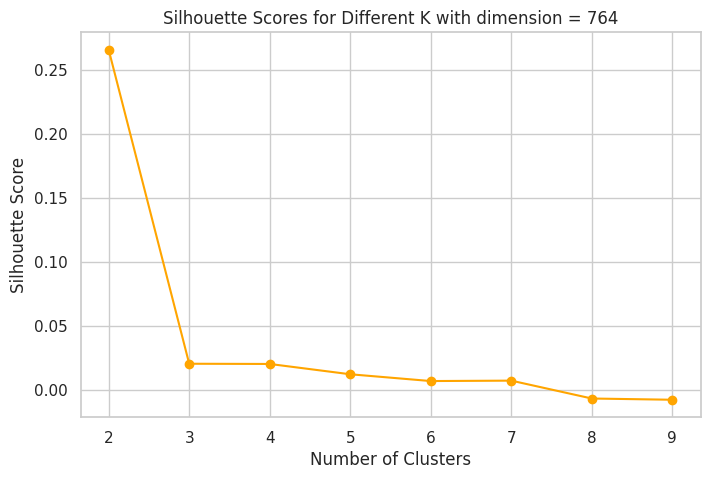

Silhouette Scores: [0.2657922316614876, 0.020570873062621044, 0.020398671079742577, 0.01234760882590417, 0.007051251211233266, 0.0073757968840361685, -0.00658721661283843, -0.007551405108050949]
Davies-Bouldin Scores: [5.156337688764362, 5.922042495133258, 5.400221928568336, 5.612244238501032, 5.488250128256651, 5.139392350368429, 4.924496249449611, 4.7795967082245925]



In [92]:
kMeansHelper(scaled_data)




# Apply K-Means with optimal clusters
  # optimal_k = 5  # Example based on silhouette/elbow
  # kmeans = KMeans(n_clusters=optimal_k, random_state=42)
  # kmeans_labels = kmeans.fit_predict(data)

Analysis of curves:

From the inertia curve, it appears the elbow has not been reached yet; optimal k maybe higher than 9.

However, for k > 2 the silhouette score is extremely low. This shows us that the silhouette score is not situable for high number dimensions of data.

For Davies-Bouldin:

> Lower index values indicate a better clustering result.



# Dimension Reduction

PCA reduced the dataset to 260 dimensions.


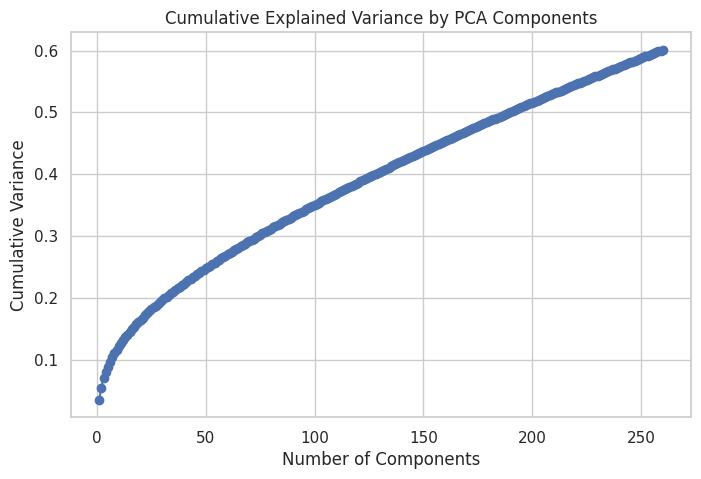

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP transformation completed.


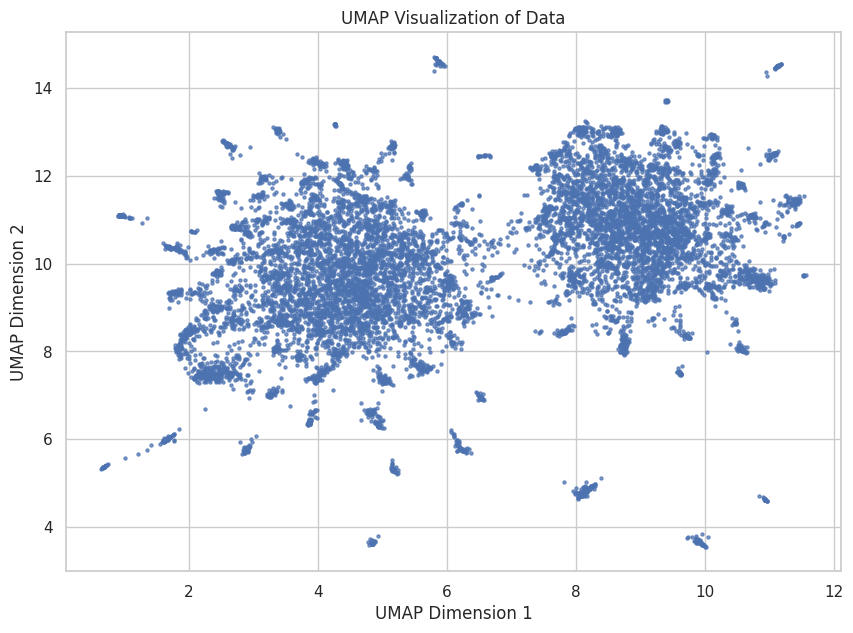

In [93]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.6)  # Retain 60% variance
pca_data = pca.fit_transform(scaled_data)
print(f"PCA reduced the dataset to {pca_data.shape[1]} dimensions.")

# Visualize variance explained by components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.show()

# Apply UMAP for dimensionality reduction to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_data = umap_reducer.fit_transform(pca_data)
print("UMAP transformation completed.")

# Visualize UMAP
plt.figure(figsize=(10, 7))
plt.scatter(umap_data[:, 0], umap_data[:, 1], s=5, alpha=0.7)
plt.title('UMAP Visualization of Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


# K-Means after Dimension Reduction

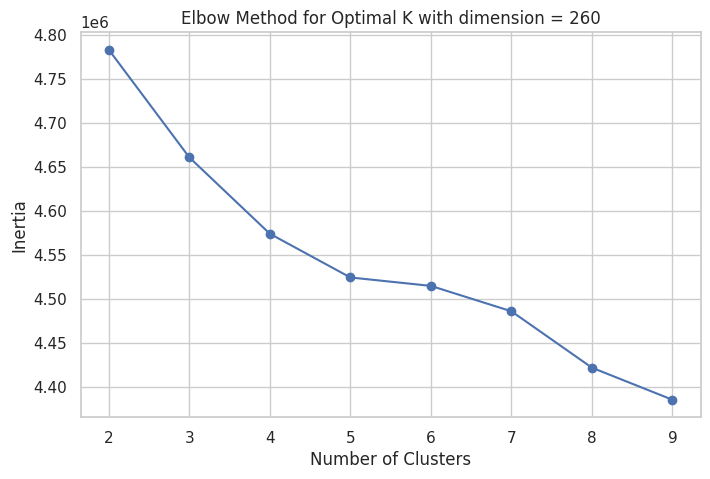

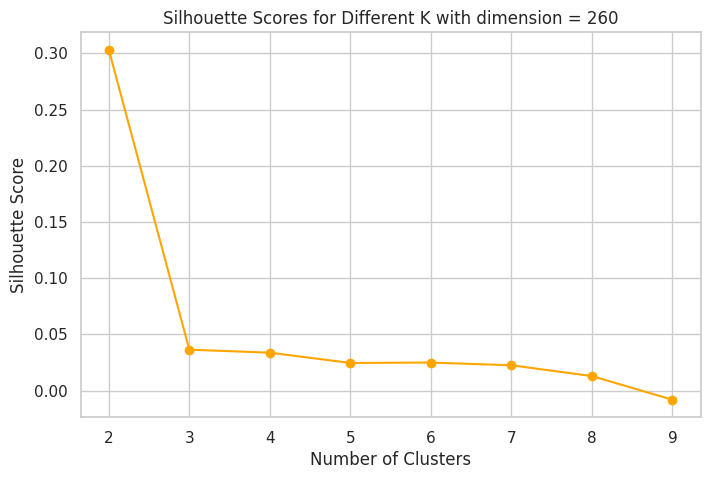

Silhouette Scores: [0.30325392899065023, 0.036322867173206486, 0.033678278470562845, 0.024511394042855104, 0.024878781864187318, 0.022448117237018863, 0.01284617207382471, -0.008225712906171976]
Davies-Bouldin Scores: [4.047945320045343, 4.4113444556131, 3.8792305696987848, 4.112927817056117, 3.632318014325129, 3.5171245696357025, 4.012002512961443, 4.139485880614058]



In [94]:
kMeansHelper(pca_data)

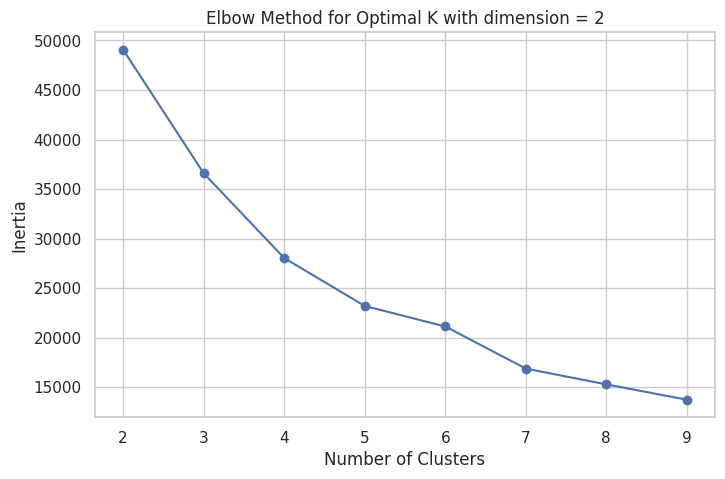

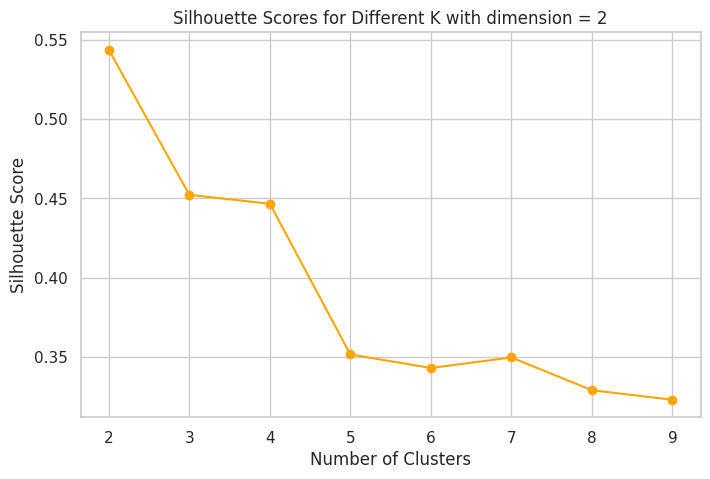

Silhouette Scores: [0.5438693, 0.45227072, 0.4466203, 0.35151705, 0.34296393, 0.34961477, 0.32893196, 0.32291713]
Davies-Bouldin Scores: [0.692800060148407, 0.942032259128608, 0.8467774882603462, 0.9838269786002412, 0.9501276271408153, 0.909648336567006, 0.9276713229703756, 0.915994278191764]



In [95]:
kMeansHelper(umap_data)

We can see that both the Silhouette and Davies-Bouldin changes with dimensions, so will find the dimension that will optimizes them.


PCA reduced the dataset to 3 dimensions.


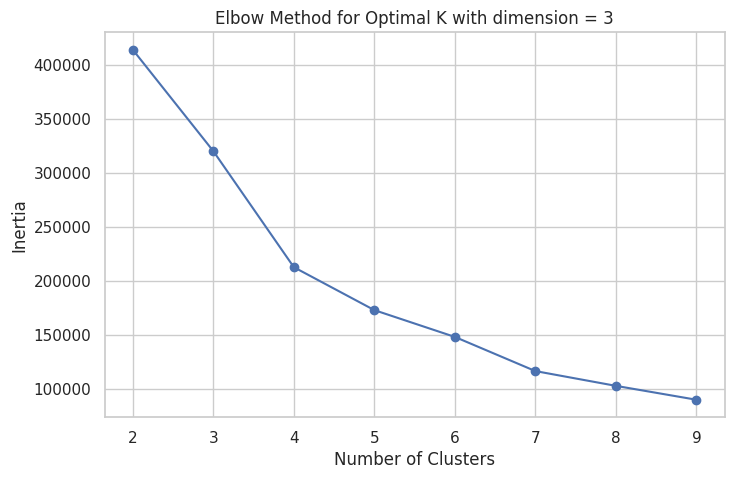

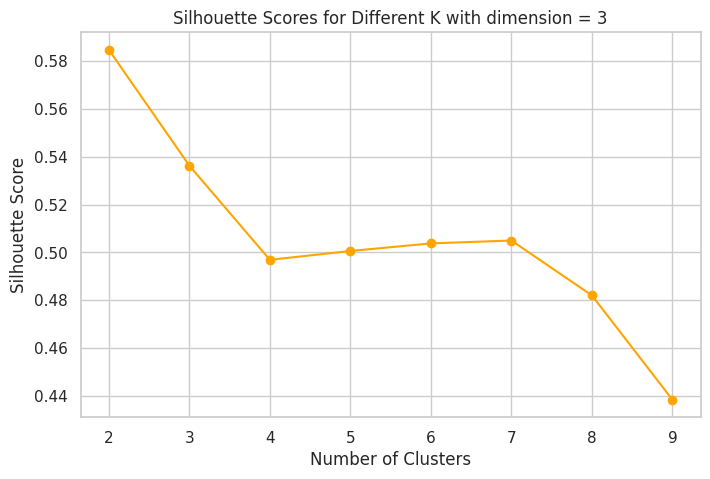

Silhouette Scores: [0.5846610065714576, 0.5362642050126032, 0.4969266194524682, 0.5006024898607582, 0.5037866440421002, 0.5049781259382652, 0.482048692616111, 0.43847468841628]
Davies-Bouldin Scores: [1.114211988909857, 0.9145663219796978, 0.7930304563306222, 0.7529042704234579, 0.744003346656484, 0.7440222355240473, 0.7952741123424736, 0.8066959222334688]


PCA reduced the dataset to 7 dimensions.


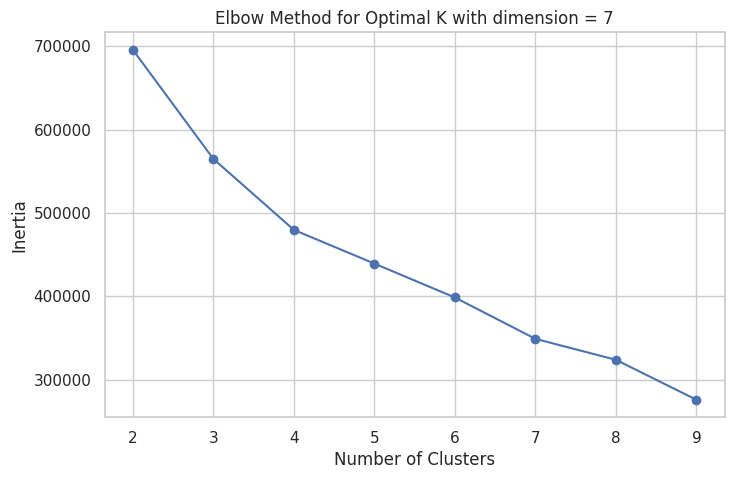

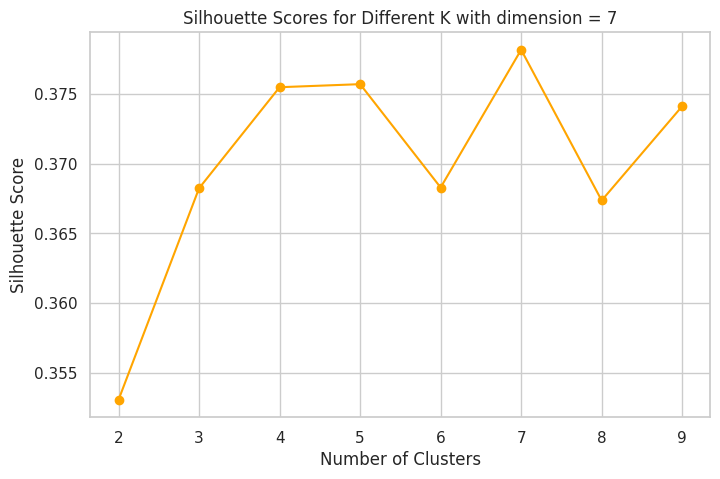

Silhouette Scores: [0.35308390078116986, 0.3682431018898233, 0.3754819248233169, 0.3757009632773152, 0.36829395011233085, 0.3781670633127905, 0.36736483553940497, 0.3741215199104835]
Davies-Bouldin Scores: [1.4290197305868177, 1.3122000876160642, 1.1732391579398236, 1.371485637458837, 1.267733713128595, 1.096844679246697, 1.1276422704777151, 1.0285155876140808]


PCA reduced the dataset to 15 dimensions.


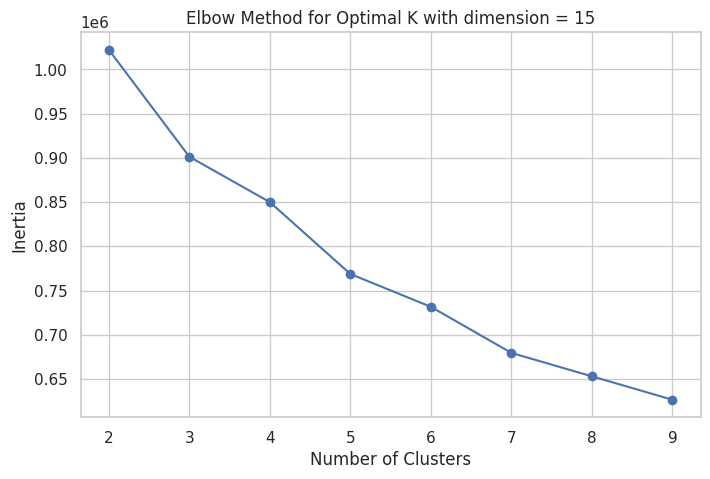

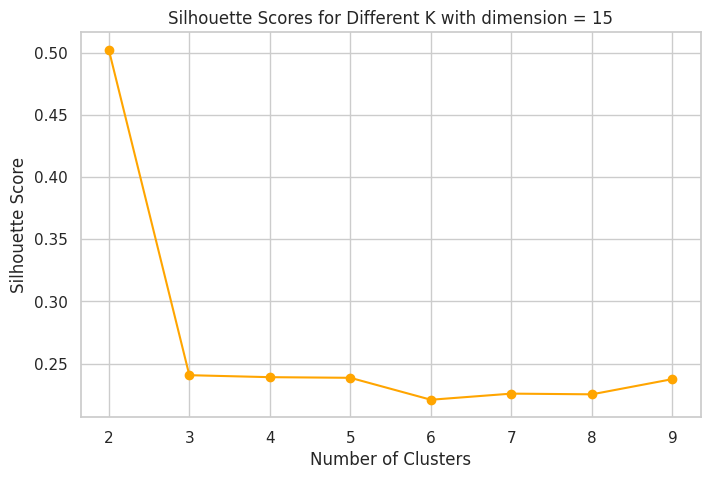

Silhouette Scores: [0.502230760181582, 0.24071922695177342, 0.23913058551157904, 0.23861901311038272, 0.22098727068988044, 0.22590764853345685, 0.22534868153930576, 0.237574123306181]
Davies-Bouldin Scores: [1.8933198101045616, 1.7023045460041741, 1.8240517667338803, 1.6693321972127044, 1.8150642342149228, 1.67298492163773, 1.6428055895415294, 1.588582685425606]


PCA reduced the dataset to 30 dimensions.


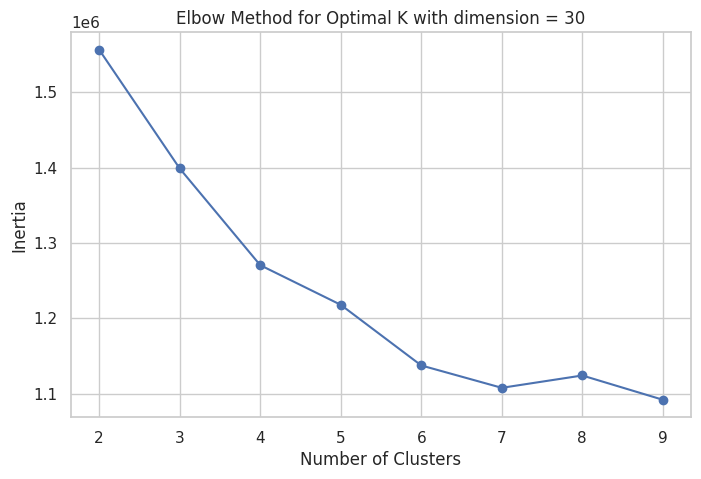

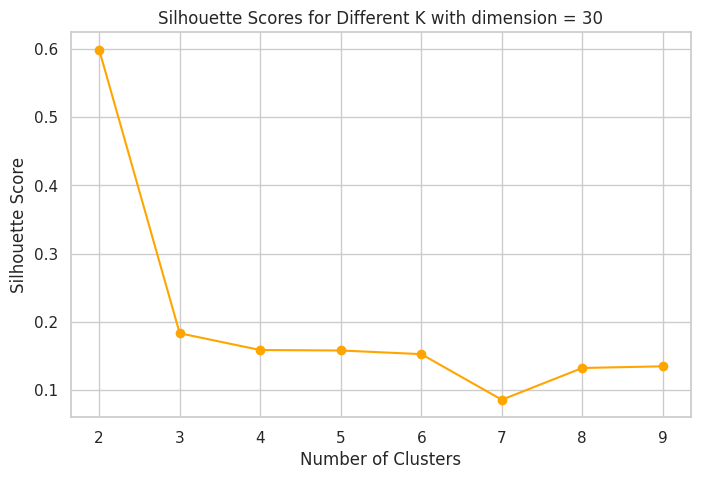

Silhouette Scores: [0.5989432286061097, 0.18340348436685347, 0.15883472618472957, 0.15817320985298128, 0.15282049688737903, 0.08596068451199934, 0.13252111557530588, 0.1349769628231438]
Davies-Bouldin Scores: [1.0636492260105521, 1.9146122607533786, 1.9318255777239703, 2.051967027352138, 1.9141808663466584, 2.0699349269785325, 2.139471327007757, 2.120242481743458]


PCA reduced the dataset to 50 dimensions.


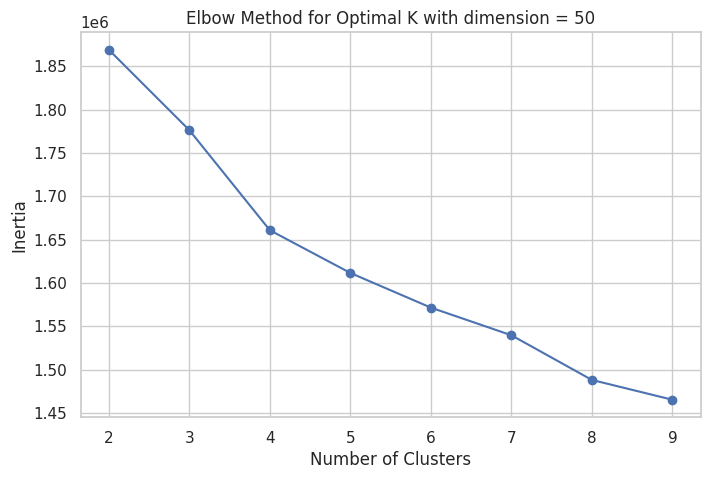

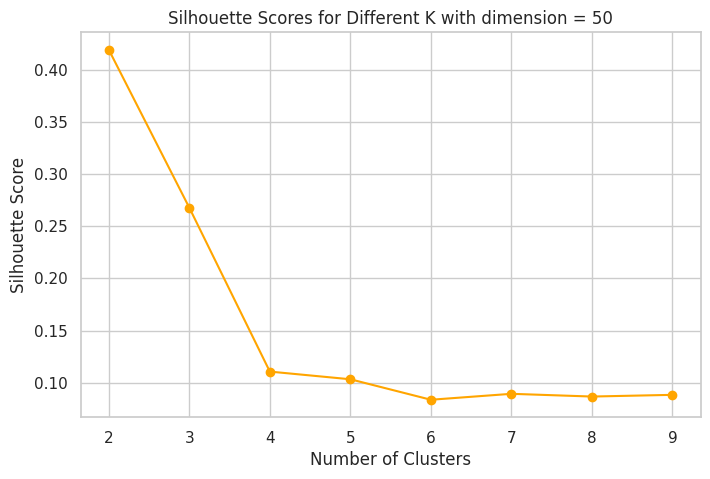

Silhouette Scores: [0.418982168372654, 0.2676742810170077, 0.11071839902793887, 0.1033575155584875, 0.0837477137556921, 0.08943259954844551, 0.0868198943260443, 0.08844633996184294]
Davies-Bouldin Scores: [2.581634912060346, 2.3913712886639864, 2.2473012217484705, 2.4332482108613713, 2.6242816277494603, 2.4503217293476593, 2.4024937421053076, 2.3774324974088534]


PCA reduced the dataset to 100 dimensions.


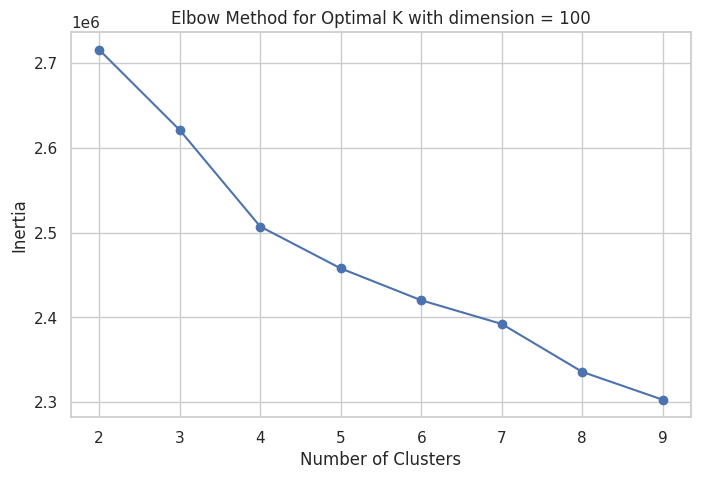

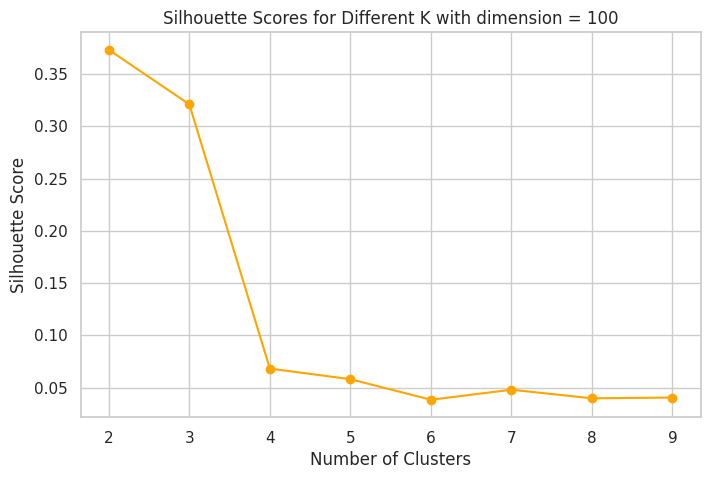

Silhouette Scores: [0.3731943779674942, 0.3209503770936351, 0.06818654498495141, 0.05803176733869376, 0.03836212522894845, 0.047951128638655235, 0.039734003029599896, 0.040455035846462276]
Davies-Bouldin Scores: [3.1062545011906955, 2.7036964957487863, 2.8277487228206306, 2.959367355599811, 3.229749852393214, 3.1325190132582845, 2.96315838409536, 2.829169845988387]



In [96]:
for dimension in [3,7,15,30,50,100]:
  data_reduced = PCA(n_components=dimension).fit_transform(scaled_data)
  print(f"\nPCA reduced the dataset to {data_reduced.shape[1]} dimensions.")
  kMeansHelper(data_reduced)



*   We reduced the dimension from 760 to 260 using PCA and then 260 to 2D using UMAP, where we noticed the Davies bouldin score was way better in 2D and the silhouette score got better too.
*   Then, we did some experiment by changing the dimension to various other like 3,7,15,30,50 and 100 and found out dimension 3 reduction score on both Silhouette and Davies bouldin has the optimal score.



# K-Means Clustering for Optimal 3 dimension

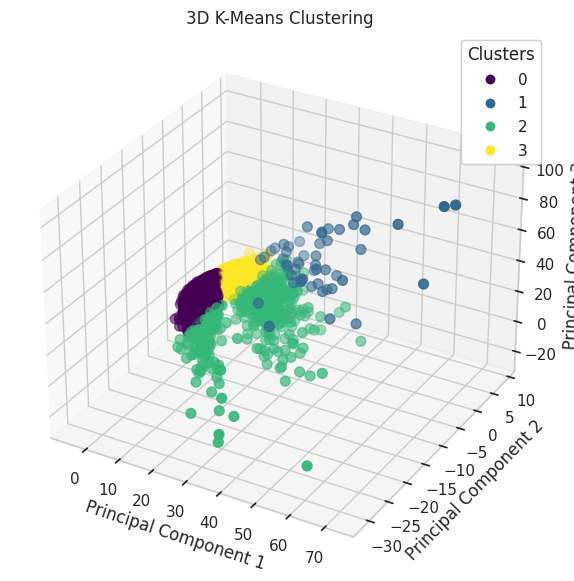

In [97]:
# Plotting 3d for kmeans clustering using matplotlib.plt


# Dimensionality reduction to 3D
pca = PCA(n_components=3)
data_3d = pca.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_3d)
inertia = kmeans.inertia_
sil_score = silhouette_score(data_3d, kmeans.labels_)
davies_bouldin_score = davies_bouldin_score(data_3d, kmeans.labels_)

import seaborn as sns

sns.set(style="whitegrid")  # Apply Seaborn style
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=kmeans.labels_, cmap='viridis', s=50)
ax.set_title('3D K-Means Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


# Evaluating the score

# References

# Print All

In [98]:
# PRINT TO PDF
# do not include the output from installation.
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert

# Clear output:
from IPython.display import clear_output
clear_output()

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/MJC_SS_Data_Mining_Final_Part_2.ipynb' --to pdf

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/MJC_SS_Data_Mining_Final_Part_2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    